# The Hodgkin-Huxley model


The **Hodgkin-Huxley model** is a mathematical model that describes how action potentials in neurons are initiated and propagated.

## Basic components

The typical Hodgkin-Huxley model treats each component of an excitable cell as an electrical element (as shown in the figure below)

![inline 30%](https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/Hodgkin-Huxley.svg/350px-Hodgkin-Huxley.svg.png)

* $C_m$ is the passive membrane capacitance
* $g_n$ are the active voltage-gated ion channels by electrical conductances (where $n$ is the specific ion channel) that depend on both voltage and time
* $g_L$ is the passive leak channel represented by a linear conductance
* $E_n$ are the gradients driving the flow of ions (determined by intra- and extracellular concentrations of ions)
* $I_p$ are the ion pumps represented by current sources 

The total current can be modeled via the following (ordinary) differential equations

$$C_m \frac{dV_m}{dt} = I_{inj} - I_K - I_{Na} - I_L =  I_{inj} - \bar{g}_K n^4 (V_m - E_K) - \bar{g}_{Na} m^3 h (V_m - E_{Na}) - \bar{g}_L (V_m - E_L)$$

$$\frac{dn}{dt} = \alpha_n (1 - n) - \beta_n n$$

$$\frac{dm}{dt} = \alpha_m (1 - m) - \beta_m m$$

$$\frac{dh}{dt} = \alpha_h (1 - h) - \beta_h h$$

* $I_{inj}$ is the injected current
* $\bar{g}_n$ are the maximum conductances for a given channel (sodium $Na$, potassium $K$, and leak $L$)
* $E_n$ are the reversal potentials for a given channel
* $n$, $m$, and $h$ are the gating variables

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
%matplotlib inline

# enable LaTeX in plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=14)

## Voltage-dependent rate variables

$\alpha$ and $\beta$ are the voltage-dependent rates at which the activation and inactivation gates are opening or closing, respectively.

Sodium ($Na$) has an activation and an inactivation gate variable. Potassium (K) only has an activation gate variable.

In [2]:
def alpha_n(V_m):
    """Voltage-dependent rate at which the potassium (K) activation gate is opening"""
    return (0.01 * (-V_m + 10)) / (np.exp((-V_m + 10) / 10) - 1)

def beta_n(V_m):
    """Voltage-dependent rate at which the potassium (K) activation gate is closing"""
    return 0.125 * np.exp(-V_m / 80)

def alpha_m(V_m):
    """Voltage-dependent rate at which the sodium (Na) activation gate is opening"""
    return (0.1 * (-V_m + 25)) / (np.exp((-V_m + 25) / 10) - 1 )

def beta_m(V_m):
    """Voltage-dependent rate at which the sodium (Na) activation gate is closing"""
    return 4 * np.exp(-V_m / 18)

def alpha_h(V_m):
    """Voltage-dependent rate at which the sodium (Na) inactivation gate is opening"""
    return 0.07 * np.exp(-V_m / 20)

def beta_h(V_m):
    """Voltage-dependent rate at which the sodium (Na) inactivation gate is closing"""
    return 1 / (np.exp((-V_m + 30) / 10) + 1)

## Visualization of voltage-dependent rate variables

* $n_\infty(V_m) = \frac{\alpha_n(V_m)}{\alpha_n(V_m) + \beta_n(V_m)} $
* $m_\infty(V_m) = \frac{\alpha_m(V_m)}{\alpha_m(V_m) + \beta_m(V_m)} $
* $h_\infty(V_m) = \frac{\alpha_h(V_m)}{\alpha_h(V_m) + \beta_h(V_m)} $

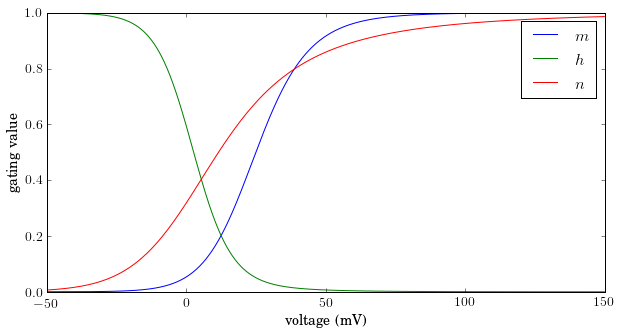

In [3]:
def n_inf(V_m):
    return alpha_n(V_m) / (alpha_n(V_m) + beta_n(V_m))

def m_inf(V_m):
    return alpha_m(V_m) / (alpha_m(V_m) + beta_m(V_m))

def h_inf(V_m):
    return alpha_h(V_m) / (alpha_h(V_m) + beta_h(V_m))

voltage = np.arange(-50, 150, 0.1)
plt.figure(figsize=(10, 5))
plt.plot(voltage, map(m_inf, voltage), label=r'$m$')
plt.plot(voltage, map(h_inf, voltage), label=r'$h$')
plt.plot(voltage, map(n_inf, voltage), label=r'$n$')
plt.xlabel(r'voltage (mV)')
plt.ylabel(r'gating value')
plt.legend()
plt.show()

## Constants

* $\bar{g}_{Na}$, $\bar{g}_{K}$, and $\bar{g}_{L}$ are the maximum conductances for sodium, potassium, and the leak channel, respectively
* $E_{Na}$, $E_{K}$, and $E_{L}$ are the Nernst reveral potentials for sodium, potassium, and the leak channel, respectively
* $C_m$ is the membrane capacitance

In [4]:
# maximum conductances
g_Na = 120
g_K = 36
g_L = 0.3

# reversal potentials
E_Na = 115
E_K = -12
E_L = 10.6

# membrane capacitance
C_m = 1

## Currents

* $I_{Na} = \bar{g}_{Na} m^3 h (V_m - E_{Na})$
* $I_{K} = \bar{g}_{K} n^4 (V_m - E_{K})$
* $I_{L} = \bar{g}_{L} (V_m - E_{L})$

In [5]:
def I_Na(V_m, m, h):
    """Current flowing through the sodium (Na) channels"""
    return g_Na * (m ** 3) * h * (V_m - E_Na)

def I_K(V_m, n):
    """Current flowing through the potassium (K) channels"""
    return g_K * (n ** 4) * (V_m - E_K)

def I_L(V_m):
    """Current flowing through the leak (L) channels"""
    return g_L * (V_m - E_L)

## Putting it all together

$$\frac{dV_m}{dt} = \frac{1}{C_m} (I_{inj} - \bar{g}_K n^4 (V_m - E_K) - \bar{g}_{Na} m^3 h (V_m - E_{Na}) - \bar{g}_L (V_m - E_L))$$

$$\frac{dn}{dt} = \alpha_n (1 - n) - \beta_n n$$

$$\frac{dm}{dt} = \alpha_m (1 - m) - \beta_m m$$

$$\frac{dh}{dt} = \alpha_h (1 - h) - \beta_h h$$

In [6]:
def dVdt(V_m, m, h, n, I_inj):
    return (1. / C_m) * (I_inj - I_Na(V_m, m, h) - I_K(V_m, n) - I_L(V_m))

def dndt(V_m, n):
    return alpha_n(V_m) * (1 - n) - beta_n(V_m) * n

def dmdt(V_m, m):
    return alpha_m(V_m) * (1 - m) - beta_m(V_m) * m

def dhdt(V_m, h):
    return alpha_h(V_m) * (1 - h) - beta_h(V_m) * h

In [7]:
T = 100 # total time (ms) 
dt = 0.025 # time step (ms)
time = np.arange(0, T, dt)

# voltage over time
V = np.zeros_like(time)

# gating variables over time
m = np.zeros_like(time)
h = np.zeros_like(time)
n = np.zeros_like(time)

# currents over time
ina = np.zeros_like(time)
ik = np.zeros_like(time)
il = np.zeros_like(time)

# set initial values
V[0] = 0.0 # normally -70 but original HH paper uses 0
m[0] = m_inf(V[0])
h[0] = h_inf(V[0])
n[0] = n_inf(V[0])

# set injected current
I_inj = np.zeros_like(time)
I_inj[500:1000] = [10] * 500
I_inj[1500:2250] = [25] * 750
I_inj[2750:3750] = [50] * 1000

In [8]:
# simulate model
for t in range(len(time) - 1):
    
    # integrate
    m[t+1] = m[t] + dmdt(V[t], m[t]) * dt
    h[t+1] = h[t] + dhdt(V[t], h[t]) * dt
    n[t+1] = n[t] + dndt(V[t], n[t]) * dt
    V[t+1] = V[t] + dVdt(V[t], m[t], h[t], n[t], I_inj[t]) * dt
    
    # keep those for plotting current
    ina[t+1] = I_Na(V[t], m[t], h[t])
    ik[t+1] = I_K(V[t], n[t])
    il[t+1] = I_L(V[t])
    

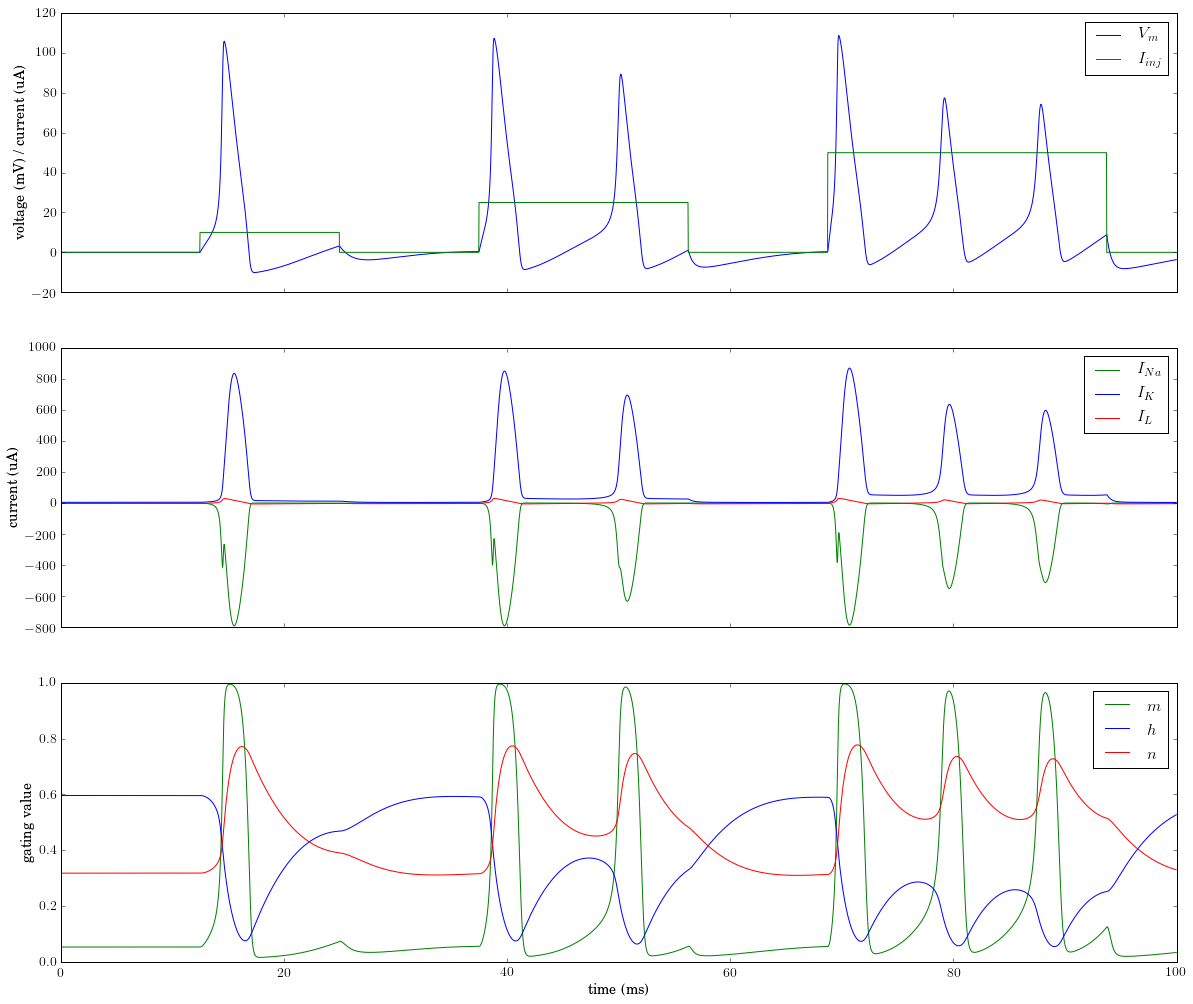

In [9]:
fig, axes = plt.subplots(3, sharex=True)
fig.set_size_inches(20, 17)
V_ax, I_ax, G_ax = axes
V_ax.plot(time, V, label=r'$V_m$', color='blue')
V_ax.plot(time, I_inj, label=r'$I_{inj}$', color='green')
V_ax.set_ylabel(r'voltage (mV) / current (uA)')
V_ax.legend()
I_ax.plot(time, ina, label=r'$I_{Na}$', color='green')
I_ax.plot(time, ik, label=r'$I_K$', color='blue')
I_ax.plot(time, il, label=r'$I_L$', color='red')
I_ax.set_ylabel(r'current (uA)')
I_ax.legend()
G_ax.plot(time, m, label=r'$m$', color='green')
G_ax.plot(time, h, label=r'$h$', color='blue')
G_ax.plot(time, n, label=r'$n$', color='red')
G_ax.set_ylabel(r'gating value')
G_ax.set_xlabel(r'time (ms)')
G_ax.legend()
plt.show()